In [1]:
import sys
sys.path.append("/home/webphy/Desktop/dnn_processor_v2/")  # just to enable `dataset`
sys.path.append("/home/webphy/Desktop/dnn_processor_v2/dataset/")  # just to enable `dataset`

import tensorflow as tf
import dataset
import numpy as np
import keras
from datetime import datetime
from keras import layers

2024-02-12 16:43:01.715095: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 16:43:01.737523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 16:43:01.737542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 16:43:01.738167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 16:43:01.742131: I tensorflow/core/platform/cpu_feature_guar

In [2]:
DEFAULT_BATCH_SIZE = 128
EPOCHS = 200
DEFAULT_INPUT_SIZE = 128

train_images_rgx = "../../dataset/train_set/*/*.jpeg"
test_images_rgx = "../../dataset/test_set/*/*.jpeg"

train_dataset, test_dataset, num_classes = dataset.create_datasets(
    train_images_rgx, test_images_rgx, DEFAULT_BATCH_SIZE, DEFAULT_INPUT_SIZE
)
train_dataset_v2, val_dataset, num_classes = dataset.create_train_val_datasets(
    train_images_rgx, DEFAULT_BATCH_SIZE, DEFAULT_INPUT_SIZE, ratio=0.1
)

2024-02-12 16:43:02.682363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 16:43:02.706068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 16:43:02.706192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
def create_model_checkpointer(save_path):
    return keras.callbacks.ModelCheckpoint(
        save_path + "weights/",
        "accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )


def create_early_stopper():
    return keras.callbacks.EarlyStopping(
        monitor="accuracy",
        min_delta=0.01,
        patience=30,
        verbose=0,
        mode="max",
        start_from_epoch=150,
    )


def create_lr_reducer_on_plateau():
    return keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy", factor=0.5, patience=10, mode="max", verbose=1, start_from_epoch=50
    )

In [4]:
x = x_in = layers.Input(shape=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE, 3))

# augmentation
x = layers.RandomFlip()(x)
x = layers.RandomBrightness(0.05, (0, 1.0))(x)


x = keras.layers.Conv2D(4, 4, 4, kernel_regularizer=keras.regularizers.L2(0.00005))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(16, 3, 2, kernel_regularizer=keras.regularizers.L2(0.00005))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(5, 1, 1, kernel_regularizer=keras.regularizers.L2(0.00005))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.L2(0.00005))(x)

# Build model
model = keras.Model(x_in, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 128, 128, 3)       0         
 rightness)                                                      
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 4)         196       
                                                                 
 activation (Activation)     (None, 32, 32, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 16)        592       
                                                             

In [5]:
optimizer = keras.optimizers.Adam()

# compile the model
model.compile(
    optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
EXP_ID = "baseline_model_v2"

# crate model checkpointer
saved_best_model_path = f"saved_models/{EXP_ID}/best_model_t/"
model.save(saved_best_model_path, True, "tf")  # save all model

model_chkp = create_model_checkpointer(saved_best_model_path)
early_stopper = create_early_stopper()
lr_reducer = create_lr_reducer_on_plateau()

# Training and validating cycle.
history = model.fit(
    train_dataset,    
    epochs=EPOCHS,    
    callbacks=[model_chkp, lr_reducer],
    verbose="auto",
)

# load best model
model.load_weights(saved_best_model_path + "weights/")

In [ ]:
# Evaluate the model accuracy on the validation set.
score = model.evaluate(test_dataset, verbose=1)

In [ ]:
model.save(saved_best_model_path + "model.h5")

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_tf_history(history):
    """
    Plots the training history of a TensorFlow model.

    Parameters:
    - history: TensorFlow training history object returned by model.fit()

    Returns:
    - None (plots the training history)
    """
    # Extracting training metrics
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    accuracy = history.history.get('accuracy', None)
    #val_accuracy = history.history.get('val_accuracy', None)

    # Plotting the training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the training and validation accuracy (if available)
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    #plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_tf_history(history)

# get metrics

In [6]:
model = keras.models.load_model("saved_models/baseline_model_v2/best_model_t/model.h5", compile=True)
model.evaluate(test_dataset)
model.evaluate(train_dataset)

2024-02-12 16:43:09.980835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


45/45 [==============================] - 0s 7ms/step - loss: 0.2029 - accuracy: 0.9321


[0.20293714106082916, 0.9321180582046509]

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [11]:
x_test = []
y_test = []

for b in test_dataset.as_numpy_iterator():
    x_test.append(b[0])
    y_test.append(b[1])

x_test = np.concatenate(x_test, 0)
y_test = np.argmax(np.concatenate(y_test, 0), -1)    

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, -1)    

labels = None # ["0","1","2","3","4"]

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred, labels=labels, average="macro"))
print("recall_score", recall_score(y_test, y_pred, labels=labels, average="macro"))
print("f1_score", f1_score(y_test, y_pred, labels=labels, average="macro"))

20/20 [==============================] - 0s 1ms/step
accuracy_score 0.9139280125195618
precision_score 0.914594286047075
recall_score 0.9135998656637045
f1_score 0.9138927561780044


In [12]:
x_train = []
y_train = []

for b in train_dataset.as_numpy_iterator():
    x_train.append(b[0])
    y_train.append(b[1])

x_train = np.concatenate(x_train, 0)
y_train = np.argmax(np.concatenate(y_train, 0), -1)    

y_pred_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_train, -1)    

labels = None # ["0","1","2","3","4"]

print("accuracy_score", accuracy_score(y_train, y_pred_train))
print("precision_score", precision_score(y_train, y_pred_train, labels=labels, average="macro"))
print("recall_score", recall_score(y_train, y_pred_train, labels=labels, average="macro"))
print("f1_score", f1_score(y_train, y_pred_train, labels=labels, average="macro"))

180/180 [==============================] - 0s 1ms/step
accuracy_score 0.9324652777777778
precision_score 0.9323361513185183
recall_score 0.9326575660698266
f1_score 0.932421835986951


# create a confusion matrix

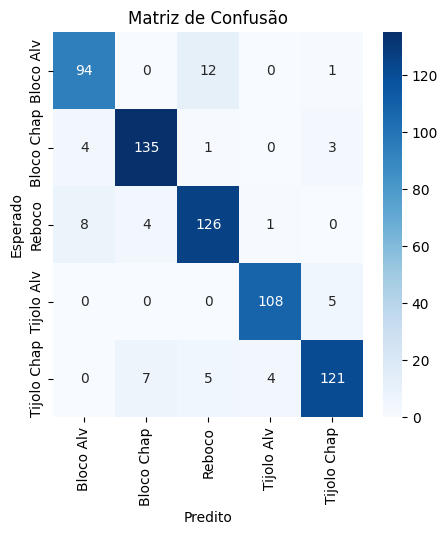

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels=None):
    """
    Plot the confusion matrix for a classification task.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - labels: List of class labels (optional).

    Returns:
    - None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # If labels are not provided, infer from unique values in y_true and y_pred
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    
    # Create a heatmap
    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    
    # Set labels and title
    plt.xlabel('Predito')
    plt.ylabel('Esperado')
    plt.title('Matriz de Confusão')
    
    plt.show()

# Example usage:


plot_confusion_matrix(y_test, y_pred, labels=['Bloco Alv', 'Bloco Chap', 'Reboco', 'Tijolo Alv', 'Tijolo Chap'])


# save model without augmentations

In [18]:
x = x_in = layers.Input(shape=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE, 3))

for l in model.layers[1:]:
    if isinstance(l, layers.RandomFlip) or isinstance(l, layers.RandomBrightness):
        continue

    x = l(x)
    
# Build model
model_clean = keras.Model(x_in, x)
model_clean.compile("adam", loss=keras.losses.CategoricalCrossentropy(True), metrics=["acc"])
model_clean.summary()
model_clean.evaluate(test_dataset)

model_clean.save("saved_models/baseline_model_v2/best_model_t/model_clean.h5")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 4)         196       
                                                                 
 activation (Activation)     (None, 32, 32, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 16)        592       
                                                                 
 activation_1 (Activation)   (None, 15, 15, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 5)         85        
                                                                 
 flatten (Flatten)           (None, 1125)              0   

                                                                 
 dense (Dense)               (None, 5)                 5630      
                                                                 
Total params: 6503 (25.40 KB)
Trainable params: 6503 (25.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
5/5 [==============================] - 0s 5ms/step - loss: 0.2590 - acc: 0.9139


/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
